In [3]:
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)

In [5]:
import KMALL

#loading the kmall file
kmall_file = r"C:\Users\neela\OneDrive\Documents\Aresty\0010_20230414_151827.kmwcd"
k = KMALL.kmall(kmall_file)

#Indexing the file to list all the datagrams
k.index_file()

#printing a report of the packet types in the file
k.report_packet_types()

             Count     Size:  Min Size  Max Size
MessageType                                     
#CHE           136      5440        40        40
#IIP             1      1106      1106      1106
#IOP             1      1246      1246      1246
#MWC           136  36599356    268044    279860
#SVP             1       112       112       112


Filter for MWC Datagrams

In [7]:
#Exctracting the number of pings 

MWC = k.Index["MessageType"] == "#MWC"
MWCIndex = k.Index[MWC]

#checking the number of pings
print(f"Total no of pings: {len(MWCIndex)}")


Total no of pings: 136


Now select and Extract a single ping

In [9]:
#Enter the ping number 
ping_num = 26

#Reading the datagram 
dg = k.read_index_row(MWCIndex.iloc[ping_num - 1])

#checking the datagram type

if dg["header"]["dgmType"] == b"MWC":
    print(f"Ping {ping_num} extracted successfully!")


Extract Beam Data for the selected Ping

In [11]:
import pandas as pd

#Extracting the beam data for the selected ping
beamdata = pd.DataFrame.from_dict(dg["beamData"])

#printing the first few rows
print(beamdata.head())

   beamPointAngReVertical_deg  startRangeSampleNum  detectedRangeInSamples  \
0                   30.000000                    0                     511   
1                   29.764708                    0                     511   
2                   29.529415                    0                     510   
3                   29.294121                    0                     506   
4                   29.058828                    0                     504   

   beamTxSectorNum  numSampleData  detectedRangeInSamplesHighResolution  \
0                0            568                            511.877014   
1                0            568                            511.308472   
2                0            566                            510.214752   
3                0            564                            506.586884   
4                0            564                            504.463287   

                               sampleAmplitude05dB_p  
0  (-128, -128, -128, -12

In [15]:
beamdata

,beamPointAngReVertical_deg,startRangeSampleNum,detectedRangeInSamples,beamTxSectorNum,numSampleData,detectedRangeInSamplesHighResolution,sampleAmplitude05dB_p
0,30.000000,0,511,0,568,511.877014,"(-128, -128, -128, -128, -128, -128, -128, -12..."
1,29.764708,0,511,0,568,511.308472,"(-128, -128, -128, -128, -128, -128, -128, -12..."
2,29.529415,0,510,0,566,510.214752,"(-128, -128, -128, -128, -128, -128, -128, -12..."
3,29.294121,0,506,0,564,506.586884,"(-128, -128, -128, -128, -128, -128, -128, -12..."
4,29.058828,0,504,0,564,504.463287,"(-128, -128, -128, -128, -128, -128, -128, -12..."
...,...,...,...,...,...,...,...
251,-29.058903,0,506,0,564,506.538818,"(-128, -128, -128, -128, -128, -128, -128, -12..."
252,-29.294197,0,506,0,564,506.228577,"(-128, -128, -128, -128, -128, -128, -128, -12..."
253,-29.529490,0,507,0,566,507.081055,"(-128, -128, -128, -128, -128, -128, -128, -12..."
254,-29.764782,0,507,0,568,507.058929,"(-128, -128, -128, -128, -128, -128, -128, -12..."


In [17]:
def pipeline(dg):
    beamAmp = pd.DataFrame.from_dict(dg['beamData']['sampleAmplitude05dB_p'])
    numsamp = dg['beamData']['numSampleData']
    SoundSp = dg["rxInfo"]["soundVelocity_mPerSec"]
    SampleFreq = dg["rxInfo"]["sampleFreq_Hz"]
    TVGFuncApplied = dg["rxInfo"]["TVGfunctionApplied"]
    TVGOffset = dg["rxInfo"]["TVGoffset_dB"]
    txBeamWidth = dg['sectorData']['txBeamWidthAlong_deg']
    beamAngle = np.array(dg["beamData"]["beamPointAngReVertical_deg"])
    
    RxBeamWidth = 1
    length = np.arange(1, len(beamAmp.columns)).tolist()
    rang = [x * 0.5 * SoundSp / SampleFreq for x in length]
    
    # Ensure the first value is a very small number to avoid division by zero issues
    rang.insert(0, 10e-9)

    # Extend range to be a matrix for element-wise operations later
    rng = np.tile(rang, (beamAmp.shape[0], 1))
    rnge = pd.DataFrame(rng).T

    # Calculate z and y coordinates
    za = -(np.cos(beamAngle * np.pi / 180) * rnge)
    ya = (np.sin(beamAngle * np.pi / 180) * rnge)
    
    z = pd.DataFrame(za).T
    y = pd.DataFrame(ya).T
    
    # Calculate Amplitude Weighting Correction (Awc)
    Awc = beamAmp / 2
    
    # Calculate TS
    X = TVGFuncApplied
    C = TVGOffset
    RTval = 10 * np.log10((np.pi / 180) * (txBeamWidth[0] * np.pi / 180))
    
    TS = (Awc + RTval * np.ones(Awc.shape)).T \
         - (float(X) * np.log10(np.ones((len(rnge), 1)) * rnge)) \
         + (40 * np.log10(np.ones((len(Awc.T), 1)) * rnge)) \
         - float(C)

    # Calculate receive angle
    recieveAngle = 1 / np.cos(beamAngle * np.pi / 180)
    
    # Calculate beam areas
    RxRad = RxBeamWidth * np.pi / 180
    langth = 2 * rnge * np.sin(RxRad / 2)
    
    TxRad = txBeamWidth[0] * np.pi / 180 * recieveAngle
    width = ((2 * np.ones([rnge.shape[0], len(TxRad)]) * rnge) * np.sin(TxRad / 2)).T
    
    beamArea = langth * width.T

    # Calculate Tau (ask about this part in metadata if needed)
    Tau = 3500 / 1e5

    # Calculate Sv
    Sv = np.zeros(TS.size)
    Vol_log = 10 * np.log10(beamArea * Tau * SoundSp / 2)
    Sv = TS - Vol_log

    return Sv, ya, za


Single Ping

C:\Users\neela\AppData\Local\Temp\ipykernel_60576\3597711863.py:13: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(ya1[:500], za1[:500], Sv1.loc[:499, :], vmin=-120, vmax=-60, cmap='inferno')
C:\Users\neela\AppData\Local\Temp\ipykernel_60576\3597711863.py:16: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


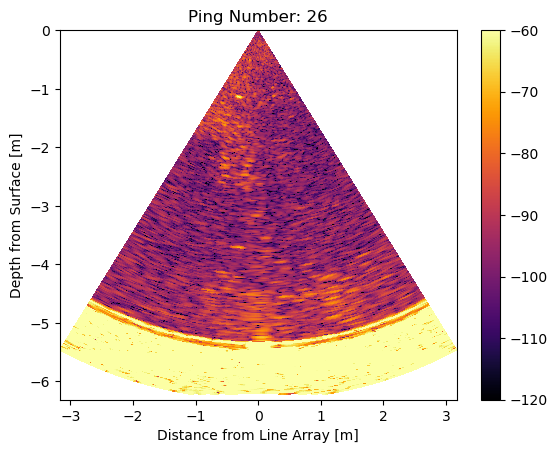

In [27]:
import matplotlib.pyplot as plt

# Run the pipeline function
Sv1, ya1, za1 = pipeline(dg)

# Create the plot
plt.figure()
plt.title('Ping Number: {}'.format(ping_num))
plt.ylabel('Depth from Surface [m]')
plt.xlabel('Distance from Line Array [m]')

# Plot the data using pcolor
plt.pcolor(ya1[:500], za1[:500], Sv1.loc[:499, :], vmin=-120, vmax=-60, cmap='inferno')

# Add a colorbar
plt.colorbar()

# Optional: Uncomment the following line for an alternative visualization
# plt.pcolor(ya, za[:200], Sv.loc[:199, :], norm='linear')

# Show the plot
plt.show()

